# Exercise 9 - NLP
### Training a language model

Exercise based on the companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

Facts about language models
*   **probabilistic models** --> one input - multiple outputs
*   **sequentially** generate tokens
*   Network basis is **Transformer**
*   Speciality is **attention**






# How to deal with language based on strings, characters


*   Transformation of characters into integers = tokenize
*   Characters, words, sequence of words


Tokenization

*   [SentencePiece](https://github.com/google/sentencepiece)
*   [tiktoken](https://github.com/openai/tiktoken)

Example

*   [OpenAI Tokenizer](https://platform.openai.com/tokenizer)



In [ ]:
# Dataset download from huggingface https://huggingface.co/datasets
# Example: tiny shakespeare dataset

import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)

with open("input.txt", "wb") as f:
    f.write(response.content)

print("File downloaded as input.txt")

### Analyze dataset


In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
# Print the length of the dataset
print("length of dataset in characters: ", len(text))

In [ ]:
# print first 50 characters
print(text[:1000])

In [ ]:
# inspect the unique characters that occur in this text

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
iots = { i:ch for i,ch in enumerate(chars) }

# Encoder: take a string, output a list of integers
encode = lambda s: [stoi[c] for c in s] 
# decoder: take a list of integers, output a string
decode = lambda l: ''.join([iots[i] for i in l]) 

print(encode("hii there"))
print(decode(encode("hii there")))

In [ ]:
# encode the entire text dataset and store it into a torch.Tensor

import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)

# Print first two entries of the dataset and the encoded version
print(data.shape, data.dtype)
print(data[:1000]) 

In [10]:
# Preparing the dataset by splitting it into train and validation
n = int(0.9*len(data)) # first 90% will be train, rest val

train_data = data[:n]
val_data = data[n:]

### Chunks are a certain size of text which is sequentially generated


In [ ]:
# How to process the dataset by defining a block size
block_size = 8

# look into what is our x and y 
train_data[:block_size]

In [ ]:
# time dimension
# x are the values and y are the predictions of the next step

x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

In [ ]:
# process chunks simultaneously

# Setting a seed
torch.manual_seed(1337)

batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # random positions with random offsets
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

# retrieve one batch of data
xb, yb = get_batch('train')

# Look into shape and content of the batch
print('inputs:')
print(xb.shape)
print(xb)

print('targets:')
print(yb.shape)
print(yb)

print('----')

# Print out training dat
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

In [ ]:
# What does our input look like?
print(xb) 

### Training a BigramLanguageModel on the shakespear dataset


*   Embedding table = encodes the vwhole vocabulary
*   Logits = score for the probability to be the next character
*   Loss = evaluate model



In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) #nn.Embedding just a wrapper of vocab size x vocab size

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits are the score of the next character; no context
        logits = self.token_embedding_table(idx) # (B,T,C) # just plugs out exactly the row of the wrapper at the specific idx


        if targets is None:
            loss = None
        else:
          # have to rearrange dimensions because cross-entropy wants them differently
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # negative loglikelihood loss
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx) # --> adapt forward as we dont need loss for all calling
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C) - last element in the time dimension
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)


# Garbage because it is just a random model without any information
idx = torch.zeros((1, 1), dtype=torch.long)

print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))


### Improve performance of BigramLanguageModel

In [16]:
# Improve performance by creating a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
for steps in range(100): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

# How to include more information in the model.
### The trick is self-attention

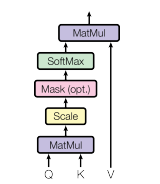

cite [https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf]

### Matrix multiplication as short introduction

In [ ]:
# "weighted aggregation over only essential information for text generation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

### Example refering to our attention mechanism

In [ ]:
# self attention 
# information of the past, like i have a vowl and i want to get the information that it is most likely that a consonant follows
# self-attention because key, query and val comes all from the same source

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention - hyperparameter head size
head_size = 16
key = nn.Linear(C, head_size, bias=False) # what do i contain
query = nn.Linear(C, head_size, bias=False) # what am i looking for
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)

# now there is a communication
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T) # affinities

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # decoder form nodes of the future dont talk to the past
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

In [ ]:
# print out the first element of the weights
wei[0] 

### Some facts about attention:

- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.

- Each example across batch dimension is of course processed completely independently and never "talk" to each other

- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.

- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)



# Code of language model focusing on decoder part of transformer

https://github.com/karpathy

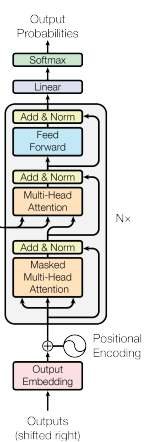

cite [https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf]

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # 256 what is the maximum context length for predictions? BLOCK SIZE WHICH IS USED
max_iters = 5000
eval_interval = 100 # 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64 # 384
n_head = 4 # 6
n_layer = 4 # 6
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad() # no backpropagation
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) # bicoder block
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """ # per token idea

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))
